In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.utils.validation import check_is_fitted

<font size="+3"><strong>Predicting Price with Size</strong></font>

## Prepare Data

Write a function named wrangle that takes a file path as an argument and returns a DataFrame.

Use your wrangle function to create a DataFrame df from the CSV file data/buenos-aires-real-estate-1.csv.

Add to your `wrangle` function so that the DataFrame it returns only includes apartments in Buenos Aires (`"Capital Federal"`) that cost less than $400,000 USD.

Add to your wrangle function so that is removes observations that are outliers in the `"surface_covered_in_m2"` column. Specifically, all observations should fall between the `0.1` and `0.9` quantiles for `"surface_covered_in_m2"`.

In [59]:
def wrangle(path):
    df = pd.read_excel(path)
    mask_ba = df["place_with_parent_names"].str.contains("Capital Federal")
    mask_apt = df["property_type"] == "apartment"
    mask_price = df["price_aprox_usd"] < 400_000
    df = df[mask_ba & mask_apt & mask_price]

    # Subset data: Remove outliers for "surface_covered_in_m2"
    low, high = df["surface_covered_in_m2"].quantile([0.1, 0.9])
    mask_area = df["surface_covered_in_m2"].between(low, high)
    df = df[mask_area]
    return df

In [60]:
df = wrangle("/content/buenos-aires-real-estate-1.xlsx")
print("df shape:", df.shape)
df.head()

df shape: (1343, 17)


,Unnamed: 0,operation,property_type,place_with_parent_names,lat-lon,price,currency,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url
4,5,sell,apartment,|Argentina|Capital Federal|Chacarita|,"-34.5846508988,-58.4546932614",129000.0,USD,1955949.6,129000.0,76.0,70.0,1697.368421,1842.857143,NaN,NaN,NaN,http://chacarita.properati.com.ar/10qlv_venta_...
9,10,sell,apartment,|Argentina|Capital Federal|Villa Luro|,"-34.6389789,-58.500115",87000.0,USD,1319128.8,87000.0,48.0,42.0,1812.500000,2071.428571,NaN,NaN,NaN,http://villa-luro.properati.com.ar/12m82_venta...
29,30,sell,apartment,|Argentina|Capital Federal|Caballito|,"-34.615847,-58.459957",118000.0,USD,1789163.2,118000.0,NaN,54.0,NaN,2185.185185,NaN,2.0,NaN,http://caballito.properati.com.ar/11wqh_venta_...
40,41,sell,apartment,|Argentina|Capital Federal|Constitución|,"-34.6252219,-58.3823825",57000.0,USD,864256.8,57000.0,42.0,42.0,1357.142857,1357.142857,5.0,2.0,364.0,http://constitucion.properati.com.ar/k2f0_vent...
41,42,sell,apartment,|Argentina|Capital Federal|Once|,"-34.6106102,-58.4125107",90000.0,USD,1364616.0,90000.0,57.0,50.0,1578.947368,1800.000000,NaN,3.0,450.0,http://once.properati.com.ar/suwa_venta_depart...


In [61]:
df.pop('Unnamed: 0')

4          5
9         10
29        30
40        41
41        42
        ... 
8589    8590
8590    8591
8593    8594
8601    8602
8604    8605
Name: Unnamed: 0, Length: 1343, dtype: int64

Create a scatter plot that shows price (`"price_aprox_usd"`) vs area (`"surface_covered_in_m2"`) in our dataset. Make sure to label your x-axis `"Area [sq meters]"` and your y-axis `"Price [USD]"`.

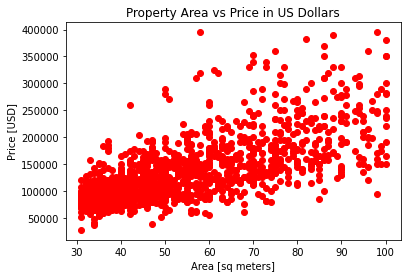

In [62]:
plt.scatter(df["surface_covered_in_m2"], df["price_aprox_usd"], color="r")
plt.xlabel("Area [sq meters]")
plt.ylabel("Price [USD]")
plt.title("Property Area vs Price in US Dollars");

Create the feature matrix named `X_train`, which you'll use to train your model. It should contain one feature only: `["surface_covered_in_m2"]`. Remember that your feature matrix should always be two-dimensional. 

In [65]:
features = ["surface_covered_in_m2"]
X_train = df[features]
X_train.shape

(1343, 1)

Create the target vector named `y_train`, which you'll use to train your model. Your target should be `"price_aprox_usd"`. Remember that, in most cases, your target vector should be one-dimensional.

In [66]:
target = "price_aprox_usd"
y_train = df[target]
y_train.shape

(1343,)

# Build Model

## Baseline

Calculate the mean of your target vector `y_train` and assign it to the variable `y_mean`

In [67]:
y_mean = y_train.mean()

Create a list named `y_pred_baseline` that contains the value of `y_mean` repeated so that it's the same length at `y`.

In [68]:
y_pred_baseline = []
for i in range(len(y_train)):
    y_pred_baseline.append(y_mean)

Add a line to the plot below that shows the relationship between the observations `X_train` and our dumb model's predictions `y_pred_baseline`. Be sure that the line color is orange, and that it has the label `"Baseline Model"`

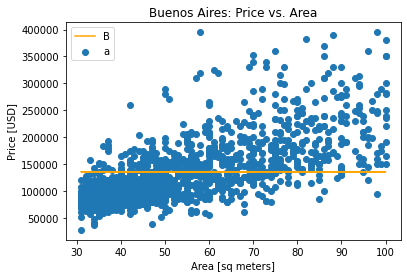

In [69]:
plt.scatter(X_train, y_train)
plt.xlabel("Area [sq meters]")
plt.ylabel("Price [USD]")
plt.title("Buenos Aires: Price vs. Area")
plt.plot(X_train, y_pred_baseline, color='orange')
plt.legend("Baseline Model");

Calculate the baseline mean absolute error for your predictions in `y_pred_baseline` as compared to the true targets in `y`

In [70]:

mae_baseline = mean_absolute_error(y_pred_baseline, y_train)

print("Mean apt price", round(y_mean, 2))
print("Baseline MAE:", round(mae_baseline, 2))

Mean apt price 135527.84
Baseline MAE: 45199.46


Instantiate a [`LinearRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) model named `model`.

In [71]:

model = LinearRegression()

Fit your model to the data, `X_train` and `y_train`.

In [72]:
model.fit(X_train, y_train)

LinearRegression()

 Using your model's [`predict`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression.predict) method, create a list of predictions for the observations in your feature matrix `X_train`. Name this array `y_pred_training`. 

In [73]:
y_pred_training = model.predict(X_train)
y_pred_training[:5]

array([169151.87330223, 106064.44707446, 133101.91545779, 106064.44707446,
       124089.42599668])

 Calculate your training mean absolute error for your predictions in `y_pred_training` as compared to the true targets in `y_train`.

In [74]:
mae_training = mean_absolute_error(y_pred_training, y_train)
print("Training MAE:", round(mae_training, 2))

Training MAE: 31248.26


Good news: Our model beat the baseline

 Extract the intercept from your model, and assign it to the variable `intercept`.

In [75]:
intercept = model.intercept_
print("Model Intercept:", intercept)
assert any([isinstance(intercept, int), isinstance(intercept, float)])

Model Intercept: 11433.307732797926


Extract the coefficient associated `"surface_covered_in_m2"` in your model, and assign it to the variable `coefficient`.

In [76]:
coefficient = model.coef_[0]
print('Model coefficient for "surface_covered_in_m2":', coefficient)
assert any([isinstance(coefficient, int), isinstance(coefficient, float)])

Model coefficient for "surface_covered_in_m2": 2253.1223652775843


Add a line to the plot below that shows the relationship between the observations in `X_train` and your model's predictions `y_pred_training`. Be sure that the line color is red, and that it has the label `"Linear Model"`.

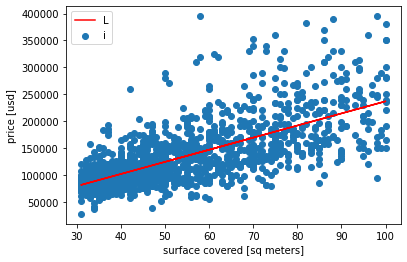

In [77]:
plt.scatter(X_train, y_train)
plt.xlabel("surface covered [sq meters]")
plt.ylabel("price [usd]")
plt.plot(X_train, y_pred_training, color='red')
plt.legend("Linear Model");


<font size="+3"><strong>Predicting Price with Location</strong></font>

Add to the `wrangle` function below so that, in the DataFrame it returns, the `"lat-lon"` column is replaced by separate `"lat"` and `"lon"` columns.

In [78]:
def wrangle(filepath):
    # Read CSV file
    df = pd.read_excel(filepath)

    # Subset data: Apartments in "Capital Federal", less than 400,000
    mask_ba = df["place_with_parent_names"].str.contains("Capital Federal")
    mask_apt = df["property_type"] == "apartment"
    mask_price = df["price_aprox_usd"] < 400_000
    df = df[mask_ba & mask_apt & mask_price]

    # Subset data: Remove outliers for "surface_covered_in_m2"
    low, high = df["surface_covered_in_m2"].quantile([0.1, 0.9])
    mask_area = df["surface_covered_in_m2"].between(low, high)
    df = df[mask_area]

    df[["lat", "lon"]] = df["lat-lon"].str.split(",", expand=True)
    df.pop("lat-lon")
    df['lat'] = df['lat'].astype(float)
    df['lon'] = df['lon'].astype(float)

 
    return df

Use your `wrangle` function to create a DataFrame `frame1` from the Excel file `data/buenos-aires-real-estate-1.xlsx`.

In [79]:
frame1 = wrangle("/content/buenos-aires-real-estate-1.xlsx")
print(frame1.info())
frame1.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1343 entries, 4 to 8604
Data columns (total 18 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Unnamed: 0                  1343 non-null   int64  
 1   operation                   1343 non-null   object 
 2   property_type               1343 non-null   object 
 3   place_with_parent_names     1343 non-null   object 
 4   price                       1343 non-null   float64
 5   currency                    1343 non-null   object 
 6   price_aprox_local_currency  1343 non-null   float64
 7   price_aprox_usd             1343 non-null   float64
 8   surface_total_in_m2         965 non-null    float64
 9   surface_covered_in_m2       1343 non-null   float64
 10  price_usd_per_m2            927 non-null    float64
 11  price_per_m2                1343 non-null   float64
 12  floor                       379 non-null    float64
 13  rooms                       1078 

,Unnamed: 0,operation,property_type,place_with_parent_names,price,currency,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url,lat,lon
4,5,sell,apartment,|Argentina|Capital Federal|Chacarita|,129000.0,USD,1955949.6,129000.0,76.0,70.0,1697.368421,1842.857143,NaN,NaN,NaN,http://chacarita.properati.com.ar/10qlv_venta_...,-34.584651,-58.454693
9,10,sell,apartment,|Argentina|Capital Federal|Villa Luro|,87000.0,USD,1319128.8,87000.0,48.0,42.0,1812.500000,2071.428571,NaN,NaN,NaN,http://villa-luro.properati.com.ar/12m82_venta...,-34.638979,-58.500115
29,30,sell,apartment,|Argentina|Capital Federal|Caballito|,118000.0,USD,1789163.2,118000.0,NaN,54.0,NaN,2185.185185,NaN,2.0,NaN,http://caballito.properati.com.ar/11wqh_venta_...,-34.615847,-58.459957
40,41,sell,apartment,|Argentina|Capital Federal|Constitución|,57000.0,USD,864256.8,57000.0,42.0,42.0,1357.142857,1357.142857,5.0,2.0,364.0,http://constitucion.properati.com.ar/k2f0_vent...,-34.625222,-58.382382
41,42,sell,apartment,|Argentina|Capital Federal|Once|,90000.0,USD,1364616.0,90000.0,57.0,50.0,1578.947368,1800.000000,NaN,3.0,450.0,http://once.properati.com.ar/suwa_venta_depart...,-34.610610,-58.412511


Use your `wrangle` function to create a DataFrame `frame2` from the Excel file `data/buenos-aires-real-estate-2.xlsx`.

In [80]:
frame2 = wrangle("/content/buenos-aires-real-estate-2.xlsx")
print(frame2.info())
frame1.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1315 entries, 2 to 8585
Data columns (total 18 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Unnamed: 0                  1315 non-null   int64  
 1   operation                   1315 non-null   object 
 2   property_type               1315 non-null   object 
 3   place_with_parent_names     1315 non-null   object 
 4   price                       1315 non-null   float64
 5   currency                    1315 non-null   object 
 6   price_aprox_local_currency  1315 non-null   float64
 7   price_aprox_usd             1315 non-null   float64
 8   surface_total_in_m2         933 non-null    float64
 9   surface_covered_in_m2       1315 non-null   float64
 10  price_usd_per_m2            891 non-null    float64
 11  price_per_m2                1315 non-null   float64
 12  floor                       390 non-null    float64
 13  rooms                       1059 

,Unnamed: 0,operation,property_type,place_with_parent_names,price,currency,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url,lat,lon
4,5,sell,apartment,|Argentina|Capital Federal|Chacarita|,129000.0,USD,1955949.6,129000.0,76.0,70.0,1697.368421,1842.857143,NaN,NaN,NaN,http://chacarita.properati.com.ar/10qlv_venta_...,-34.584651,-58.454693
9,10,sell,apartment,|Argentina|Capital Federal|Villa Luro|,87000.0,USD,1319128.8,87000.0,48.0,42.0,1812.500000,2071.428571,NaN,NaN,NaN,http://villa-luro.properati.com.ar/12m82_venta...,-34.638979,-58.500115
29,30,sell,apartment,|Argentina|Capital Federal|Caballito|,118000.0,USD,1789163.2,118000.0,NaN,54.0,NaN,2185.185185,NaN,2.0,NaN,http://caballito.properati.com.ar/11wqh_venta_...,-34.615847,-58.459957
40,41,sell,apartment,|Argentina|Capital Federal|Constitución|,57000.0,USD,864256.8,57000.0,42.0,42.0,1357.142857,1357.142857,5.0,2.0,364.0,http://constitucion.properati.com.ar/k2f0_vent...,-34.625222,-58.382382
41,42,sell,apartment,|Argentina|Capital Federal|Once|,90000.0,USD,1364616.0,90000.0,57.0,50.0,1578.947368,1800.000000,NaN,3.0,450.0,http://once.properati.com.ar/suwa_venta_depart...,-34.610610,-58.412511


Use [`pd.concat`](https://pandas.pydata.org/docs/reference/api/pandas.concat.html) to concatenate `frame1` and `frame2` into a new DataFrame `df`. Make sure you set the `ignore_index` argument to `True`.

In [81]:
df = pd.concat([frame1, frame2], ignore_index = True)
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2658 entries, 0 to 2657
Data columns (total 18 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Unnamed: 0                  2658 non-null   int64  
 1   operation                   2658 non-null   object 
 2   property_type               2658 non-null   object 
 3   place_with_parent_names     2658 non-null   object 
 4   price                       2658 non-null   float64
 5   currency                    2658 non-null   object 
 6   price_aprox_local_currency  2658 non-null   float64
 7   price_aprox_usd             2658 non-null   float64
 8   surface_total_in_m2         1898 non-null   float64
 9   surface_covered_in_m2       2658 non-null   float64
 10  price_usd_per_m2            1818 non-null   float64
 11  price_per_m2                2658 non-null   float64
 12  floor                       769 non-null    float64
 13  rooms                       2137 

,Unnamed: 0,operation,property_type,place_with_parent_names,price,currency,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url,lat,lon
0,5,sell,apartment,|Argentina|Capital Federal|Chacarita|,129000.0,USD,1955949.6,129000.0,76.0,70.0,1697.368421,1842.857143,NaN,NaN,NaN,http://chacarita.properati.com.ar/10qlv_venta_...,-34.584651,-58.454693
1,10,sell,apartment,|Argentina|Capital Federal|Villa Luro|,87000.0,USD,1319128.8,87000.0,48.0,42.0,1812.500000,2071.428571,NaN,NaN,NaN,http://villa-luro.properati.com.ar/12m82_venta...,-34.638979,-58.500115
2,30,sell,apartment,|Argentina|Capital Federal|Caballito|,118000.0,USD,1789163.2,118000.0,NaN,54.0,NaN,2185.185185,NaN,2.0,NaN,http://caballito.properati.com.ar/11wqh_venta_...,-34.615847,-58.459957
3,41,sell,apartment,|Argentina|Capital Federal|Constitución|,57000.0,USD,864256.8,57000.0,42.0,42.0,1357.142857,1357.142857,5.0,2.0,364.0,http://constitucion.properati.com.ar/k2f0_vent...,-34.625222,-58.382382
4,42,sell,apartment,|Argentina|Capital Federal|Once|,90000.0,USD,1364616.0,90000.0,57.0,50.0,1578.947368,1800.000000,NaN,3.0,450.0,http://once.properati.com.ar/suwa_venta_depart...,-34.610610,-58.412511


## Explore

In this lesson, we're building a multiple linear regression model that predicts price based on two features, `"lon"` and `"lat"`. This means that our data visualizations now have to communicate three pieces of information: Longitude, latitude, and price. How can we represent these three attributes on a two-dimensional screen?

One option is to incorporate color into our scatter plot. For example, in the Mapbox scatter plot below, the location of each point represents latitude and longitude, and color represents price.

In [82]:


fig = px.scatter_mapbox(
    df,  # Our DataFrame
    lat="lat",
    lon="lon",
    width=600,  # Width of map
    height=600,  # Height of map
    color="price",
    hover_data=["price_aprox_usd"],  # Display price when hovering mouse over house
)

fig.update_layout(mapbox_style="open-street-map")

fig.show()

Another option is to add a third dimension to our scatter plot. We can plot longitude on the x-axis and latitude on the y-axis (like we do in the map above), and then add a z-axis with price.

Complete the code below to create a 3D scatter plot, with `"lon"` on the x-axis, `"lat"` on the y-axis, and `"price_aprox_usd"` on the z-axis.

In [83]:
# Create 3D scatter plot
fig = px.scatter_3d(
    df,
    x="lon",
    y="lat",
    z="price",
    labels={"lon": "longitude", "lat": "latitude", "price_aprox_usd": "price"},
    width=600,
    height=500,
)

# Refine formatting
fig.update_traces(
    marker={"size": 4, "line": {"width": 2, "color": "DarkSlateGrey"}},
    selector={"mode": "markers"},
)

# Display figure
fig.show()

## Split

 Create the feature matrix named `X_train`. It should contain two features: `["lon", "lat"]`. 


In [86]:
features = ["lon", "lat"]
X_train = df[features]

 Create the target vector named `y_train`, which you'll use to train your model. Your target should be `"price_aprox_usd"`. Remember that, in most cases, your target vector should be one-dimensional.

In [87]:
target = "price_aprox_usd"
y_train = df[target]

# Build Model

## Baseline

Calculate the mean of your target vector `y_train` and assign it to the variable `y_mean`.

In [88]:
y_mean = y_train.mean()
y_mean

134732.9734048155

Create a list named `y_pred_baseline` that contains the value of `y_mean` repeated so that it's the same length at `y_train`.

In [89]:
y_pred_baseline = []
for i in range(len(y_train)):
    y_pred_baseline.append(y_mean)

Calculate the baseline mean absolute error for your predictions in `y_pred_baseline` as compared to the true targets in `y_train`.

In [90]:
from sklearn.metrics import mean_absolute_error
mae_baseline = mean_absolute_error(y_pred_baseline, y_train)
print("Mean apt price", round(y_mean, 2))
print("Baseline MAE:", round(mae_baseline, 2))

Mean apt price 134732.97
Baseline MAE: 45422.75


##Imputation

When you need to build a model using features that contain missing values, one helpful tool is the scikit-learn transformer [`SimpleImputer`](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html). In order to use it, we need to start by instantiating the transformer. 

In [91]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer()

 Fit your transformer `imputer` to the feature matrix `X`.

In [92]:
imputer.fit(X_train)

SimpleImputer()

Use your `imputer` to transform the feature matrix `X_train`. Assign the transformed data to the variable `XT_train`

In [93]:
XT_train = imputer.transform(X_train)
pd.DataFrame(XT_train, columns=X_train.columns).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2658 entries, 0 to 2657
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   lon     2658 non-null   float64
 1   lat     2658 non-null   float64
dtypes: float64(2)
memory usage: 41.7 KB


Create a pipeline named `model` that contains a `SimpleImputer` transformer followed by a `LinearRegression` predictor.

In [94]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression

regression = LinearRegression()

model = Pipeline([
    ("Imputer", imputer),
    ("Linear Regression", regression)
])

Fit your model to the data, `X_train` and `y_train`.

In [95]:
model.fit(X_train, y_train)

Pipeline(steps=[('Imputer', SimpleImputer()),
                ('Linear Regression', LinearRegression())])

## Evaluate

In [96]:
y_pred_training = model.predict(X_train)
mae_training = mean_absolute_error(y_pred_training, y_train)
print("Training MAE:", round(mae_training, 2))

Training MAE: 42962.72


Extract the intercept and coefficients for your model. 

In [97]:
intercept = model.named_steps["Linear Regression"].intercept_
coefficients = model.named_steps["Linear Regression"].coef_

<font size="+3"><strong>Predicting Price with Neighborhood</strong></font>

Use [`glob`](https://docs.python.org/3/library/glob.html#glob.glob) to create a list that contains the filenames for all the Buenos Aires real estate CSV files in the `data` directory. Assign this list to the variable name `files`.

In [98]:
from glob import glob

files = glob("/content/buenos-aires-real-estate*")
files

['/content/buenos-aires-real-estate-3.xlsx',
 '/content/buenos-aires-real-estate-2.xlsx',
 '/content/buenos-aires-real-estate-5.xlsx',
 '/content/buenos-aires-real-estate-1.xlsx',
 '/content/buenos-aires-real-estate-4.xlsx']

Modify your `wrangle` function to create a new feature `"neighborhood"`. You can find the neighborhood for each property in the `"place_with_parent_names"` column. For example, a property with the place name `"|Argentina|Capital Federal|Palermo|"` is located in the neighborhood is `"Palermo"`. Also, your function should drop the `"place_with_parent_names"` column.

In [99]:
def wrangle(filepath):
    # Read Excel file
    df = pd.read_excel(filepath)

    # Subset data: Apartments in "Capital Federal", less than 400,000
    mask_ba = df["place_with_parent_names"].str.contains("Capital Federal")
    mask_apt = df["property_type"] == "apartment"
    mask_price = df["price_aprox_usd"] < 400_000
    df = df[mask_ba & mask_apt & mask_price]

    # Subset data: Remove outliers for "surface_covered_in_m2"
    low, high = df["surface_covered_in_m2"].quantile([0.1, 0.9])
    mask_area = df["surface_covered_in_m2"].between(low, high)
    df = df[mask_area]

    # Split "lat-lon" column
    df[["lat", "lon"]] = df["lat-lon"].str.split(",", expand=True).astype(float)
    df.drop(columns="lat-lon", inplace=True)

    new_df = df["place_with_parent_names"].str.split("|", expand=True)
    new_df.head(5)
    df['neighborhood'] = new_df[3]
    df.drop(columns="place_with_parent_names", inplace=True)

    return df

Use your `wrangle` function in a `for` loop to create a list named `frames`. The list should the cleaned DataFrames created from the CSV filenames your collected in `files`.

In [100]:
frames = []
for i in range(len(files)):
    frames.append(wrangle(files[i]))

Use [`pd.concat`](https://pandas.pydata.org/docs/reference/api/pandas.concat.html) to concatenate the items in `frames` into a single DataFrame `df`. Make sure you set the `ignore_index` argument to `True`.

In [101]:
df = pd.concat([frames[0], frames[1], frames[2], frames[3], frames[4]], ignore_index= True)
df.info

<bound method DataFrame.info of       Unnamed: 0 operation property_type      price currency  \
0              8      sell     apartment   120000.0      USD   
1             21      sell     apartment    89000.0      USD   
2             22      sell     apartment   183495.0      USD   
3             42      sell     apartment    95000.0      USD   
4             44      sell     apartment    95000.0      USD   
...          ...       ...           ...        ...      ...   
6577        8595      sell     apartment   227000.0      USD   
6578        8601      sell     apartment    85267.0      USD   
6579        8602      sell     apartment  1200000.0      ARS   
6580        8603      sell     apartment   240000.0      USD   
6581        8604      sell     apartment   844779.0      ARS   

      price_aprox_local_currency  price_aprox_usd  surface_total_in_m2  \
0                     1819488.00        120000.00                  NaN   
1                     1349453.60         89000.00  

Create your feature matrix `X_train` and target vector `y_train`. `X_train` should contain one feature: `"neighborhood"`. Your target is `"price_aprox_usd"`.

In [102]:
target = "price_aprox_usd"
features = ["neighborhood"]
y_train = df[target]
X_train = df[features]

# Build Model

In order to create our model we need to **encode** that information so that it's represented numerically. The good news is that there are lots of transformers that can do this. Here, we'll use the one from the [Category Encoders](https://contrib.scikit-learn.org/category_encoders/index.html) library, called a [`OneHotEncoder`](https://contrib.scikit-learn.org/category_encoders/onehot.html).

First, instantiate a `OneHotEncoder` named `ohe`. Make sure to set the `use_cat_names` argument to `True`. Next, fit your transformer to the feature matrix `X_train`. Finally, use your encoder to transform the feature matrix `X_train`, and assign the transformed data to the variable `XT_train`.

In [103]:
!pip install category_encoders

In [104]:
from category_encoders import OneHotEncoder

ohe = OneHotEncoder(use_cat_names=True)
ohe.fit(X_train)
XT_train = ohe.transform(X_train)
print(XT_train.shape)
XT_train.head()

(6582, 57)


,neighborhood_Villa General Mitre,neighborhood_Palermo,neighborhood_Saavedra,neighborhood_Villa del Parque,neighborhood_Belgrano,neighborhood_Coghlan,neighborhood_Chacarita,neighborhood_Boedo,neighborhood_Caballito,neighborhood_Monserrat,...,neighborhood_Versalles,neighborhood_Villa Lugano,neighborhood_Parque Avellaneda,neighborhood_Las Cañitas,neighborhood_Villa Soldati,neighborhood_Parque Chas,neighborhood_Velez Sarsfield,neighborhood_Pompeya,neighborhood_Villa Real,neighborhood_Catalinas
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


 Create a pipeline named `model` that contains a `OneHotEncoder` transformer and a `LinearRegression` predictor. Then fit your model to the training data. 

In [105]:
from sklearn.pipeline import Pipeline
regression = LinearRegression()

model = Pipeline([
    ('OneHotEncoder', ohe),
    ('LinearRegression', regression)
])
model.fit(X_train, y_train)

Pipeline(steps=[('OneHotEncoder',
                 OneHotEncoder(cols=['neighborhood'], use_cat_names=True)),
                ('LinearRegression', LinearRegression())])

## Evaluate

 First, create a list of predictions for the observations in your feature matrix `X_train`. Name this list `y_pred_training`. Then calculate the training mean absolute error for your predictions in `y_pred_training` as compared to the true targets in `y_train`.

In [106]:
y_pred_training = model.predict(X_train)
mae_training = mean_absolute_error(y_pred_training, y_train)
print("Training MAE:", round(mae_training, 2))

Training MAE: 39337.0


<font size="+3"><strong>Predicting Price with Size, Location, and Neighborhood</strong></font>

The first thing we need to consider when trying to use all the features `df` is **missing values**. While it's true you can impute missing values, there still needs to be enough data in a column to do a good imputation. A general rule is that, if more than half of the data in a column is missing, it's better to drop it then try imputing.

Take a look at the output from `df.info()` above. Are there columns where more than half of the values are `NaN`? If so, those columns need to go! 

Modify your `wrangle` function to drop any columns that are more than half `NaN` values. Be sure to rerun all the cells above before you continue.

In [123]:
def wrangle(filepath):
    # Read Excel file
    df = pd.read_excel(filepath)

    # Subset data: Apartments in "Capital Federal", less than 400,000
    mask_ba = df["place_with_parent_names"].str.contains("Capital Federal")
    mask_apt = df["property_type"] == "apartment"
    mask_price = df["price_aprox_usd"] < 400_000
    df = df[mask_ba & mask_apt & mask_price]

    # Subset data: Remove outliers for "surface_covered_in_m2"
    low, high = df["surface_covered_in_m2"].quantile([0.1, 0.9])
    mask_area = df["surface_covered_in_m2"].between(low, high)
    df = df[mask_area]

    # Split "lat-lon" column
    df[["lat", "lon"]] = df["lat-lon"].str.split(",", expand=True).astype(float)
    df.drop(columns="lat-lon", inplace=True)

    new_df = df["place_with_parent_names"].str.split("|", expand=True)
    new_df.head(5)
    df['neighborhood'] = new_df[3]
    df.drop(columns="place_with_parent_names", inplace=True)

    missing = df.isnull().sum()/len(df)*100
    col_list = list(missing.index)
    for i in range(len(missing)):
      if missing[i] > 50:
        df.drop(columns=col_list[i], inplace=True)

    check_cardinality(df)
    df.drop(columns=["price_aprox_local_currency", "price","price_usd_per_m2","price_per_m2", "currency"], inplace=True)
    df.drop(columns=["surface_total_in_m2", "rooms"], inplace=True)

    return df

In [124]:
files = glob("/content/buenos-aires-real-estate*")
files

['/content/buenos-aires-real-estate-3.xlsx',
 '/content/buenos-aires-real-estate-2.xlsx',
 '/content/buenos-aires-real-estate-5.xlsx',
 '/content/buenos-aires-real-estate-1.xlsx',
 '/content/buenos-aires-real-estate-4.xlsx']

In [125]:
frames = []
for i in range(len(files)):
    frames.append(wrangle(files[i]))
df = pd.concat([frames[0], frames[1], frames[2], frames[3], frames[4]], ignore_index= True)
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6582 entries, 0 to 6581
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             6582 non-null   int64  
 1   price_aprox_usd        6582 non-null   float64
 2   surface_covered_in_m2  6582 non-null   float64
 3   lat                    6316 non-null   float64
 4   lon                    6316 non-null   float64
 5   neighborhood           6582 non-null   object 
dtypes: float64(4), int64(1), object(1)
memory usage: 308.7+ KB
None


,Unnamed: 0,price_aprox_usd,surface_covered_in_m2,lat,lon,neighborhood
0,8,120000.0,55.0,-34.616004,-58.470506,Villa General Mitre
1,21,89000.0,37.0,-34.584712,-58.444927,Palermo
2,22,183495.0,57.0,-34.554652,-58.493644,Saavedra
3,42,95000.0,47.0,-34.610581,-58.479625,Villa del Parque
4,44,95000.0,35.0,-34.558227,-58.458357,Belgrano


In [126]:
df.drop(columns="Unnamed: 0", inplace=True)
df.head()

,price_aprox_usd,surface_covered_in_m2,lat,lon,neighborhood
0,120000.0,55.0,-34.616004,-58.470506,Villa General Mitre
1,89000.0,37.0,-34.584712,-58.444927,Palermo
2,183495.0,57.0,-34.554652,-58.493644,Saavedra
3,95000.0,47.0,-34.610581,-58.479625,Villa del Parque
4,95000.0,35.0,-34.558227,-58.458357,Belgrano


The next thing we need to look out for are categorical columns with **low or high cardinality**. If there's only one category in a column, it won't provide any unique information to our model. At the other extreme, columns where nearly every row has its own category won't help our model in identifying useful trends in the data.

Let's take a look at the cardinality of our features.

In [122]:
def check_cardinality(df):
  df_categorical = df.select_dtypes(exclude="number")
  for i in df_categorical.columns:    
     if len(df_categorical[i].unique())==1 or len(df_categorical[i].unique()) > 100:
        df.drop(columns=i, inplace=True)

  return df

 Modify your `wrangle` function to drop high- and low-cardinality categorical features.

It's also important for us to drop any columns that would constitute **leakage**, that is, features that were created using our target or that would give our model information that it won't have access to when it's deployed. 

 Modify your `wrangle` function to drop any features that would constitute leakage. 

In [ ]:
#Add this code
df.drop(columns=["price_aprox_local_currency", "price","price_usd_per_m2","price_per_m2", "currency"], inplace=True)

Finally, the last issue we need to keep an eye out for is **multicollinearity**, that is, features in our feature matrix that are highly correlated with each other. A good way to detect this is to use a heatmap. Let's make one!

In [ ]:
test_df = df.copy().dropna(axis=0)
test_df_numeric = test_df.select_dtypes(include="number")
corr = test_df_numeric.corr(method="pearson")
sns.heatmap(corr)

Modify your `wrangle` function to remove columns so that there are no strongly correlated features in your feature matrix.

In [ ]:
#Add this code
df.drop(columns=["surface_total_in_m2", "rooms"], inplace=True)

Create your feature matrix `X_train` and target vector `y_train`. Your target is `"price_aprox_usd"`. Your features should be all the columns that remain in the DataFrame you cleaned above.

In [127]:
y_train = df.pop("price_aprox_usd")
X_train = df

In [128]:
X_train.head()

,surface_covered_in_m2,lat,lon,neighborhood
0,55.0,-34.616004,-58.470506,Villa General Mitre
1,37.0,-34.584712,-58.444927,Palermo
2,57.0,-34.554652,-58.493644,Saavedra
3,47.0,-34.610581,-58.479625,Villa del Parque
4,35.0,-34.558227,-58.458357,Belgrano


Create a pipeline named `model` that contains a `OneHotEncoder`, `SimpleImputer`, and `Ridge` predictor.

In [129]:
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline

ohe = OneHotEncoder(use_cat_names=True)
imputer = SimpleImputer()
ridge = Ridge()

model = Pipeline([
    ("OneHotEncoder", ohe),
    ("SimpleImputer", imputer),
    ("Ridge", ridge)
])
model.fit(X_train, y_train)

Pipeline(steps=[('OneHotEncoder',
                 OneHotEncoder(cols=['neighborhood'], use_cat_names=True)),
                ('SimpleImputer', SimpleImputer()), ('Ridge', Ridge())])

Calculate the training mean absolute error for your predictions as compared to the true targets in `y_train`.

In [130]:
y_pred = model.predict(X_train)
mae = mean_absolute_error(y_pred, y_train)
print("Training MAE:", mae)

Training MAE: 24207.107190330295


Create a function `make_prediction` that takes four arguments (`area`, `lat`, `lon`, and `neighborhood`) and returns your model's prediction for an apartment price.

In [131]:
def make_prediction(area, lat, lon, neighborhood):
    columns = ["surface_covered_in_m2", "lat", "lon", "neighborhood"]
    df = pd.DataFrame([[area, lat, lon, neighborhood]], columns=columns)
    prediction = model.predict(df)
    return f"Predicted apartment price: ${prediction}"

Let's see if your function works. Run the cell below to find out!

In [132]:
make_prediction(110, -34.60, -58.46, "Villa Crespo")

'Predicted apartment price: $[250775.11270377]'

Add your `make_prediction` to the interact widget below, run the cell, and then adjust the widget to see how predicted apartment price changes. 

- Create an interact function in Jupyter Widgets.

In [134]:
from ipywidgets import Dropdown, FloatSlider, IntSlider, interact

interact(
    make_prediction,
    area=IntSlider(
        min=X_train["surface_covered_in_m2"].min(),
        max=X_train["surface_covered_in_m2"].max(),
        value=X_train["surface_covered_in_m2"].mean(),
    ),
    lat=FloatSlider(
        min=X_train["lat"].min(),
        max=X_train["lat"].max(),
        step=0.01,
        value=X_train["lat"].mean(),
    ),
    lon=FloatSlider(
        min=X_train["lon"].min(),
        max=X_train["lon"].max(),
        step=0.01,
        value=X_train["lon"].mean(),
    ),
    neighborhood=Dropdown(options=sorted(X_train["neighborhood"].unique())),
);

interactive(children=(IntSlider(value=53, description='area', max=101, min=30), FloatSlider(value=-34.59890626…